In [ ]:
! pip install psycopg2-binary
# Import dependencies
import pandas as pd # Data manipulation
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
import psycopg2
import json
from sqlalchemy import create_engine

**Loading and Preprocessing Loans Encoded Data**

In [3]:
# Load credentials
with open("../../db_config.json") as f:
    config = json.load(f)


In [4]:
# Connect to PostgreSQL
conn = psycopg2.connect(
    host=config["host"],
    port=config["port"],
    database=config["database"],
    user=config["user"],
    password=config["password"]
)

# Create SQLAlchemy engine
engine = create_engine(f"postgresql+psycopg2://{config['user']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}")


In [5]:
df_borrower = pd.read_sql("SELECT * FROM borrower_info;", engine)
df_borrower.head()

,member_id,home_ownership,merged_annual_inc,merged_dti,emp_length_grouped,clean_verification_status,merged_purpose
0,1,RENT,55000.0,18.24,10+ years,Not Verified,Debt-related
1,3,MORTGAGE,59280.0,10.51,4-6 years,Verified,Debt-related
2,5,MORTGAGE,57250.0,26.35,10+ years,Not Verified,Debt-related
3,6,MORTGAGE,152500.0,37.94,10+ years,Not Verified,Debt-related
4,9,MORTGAGE,53580.0,21.16,10+ years,Verified,Debt-related


In [6]:
df_loan = pd.read_sql("SELECT * FROM loan_info;", engine)
df_loan.head()

,loan_id,member_id,funded_amnt,term,int_rate,grade,loan_status
0,loan1,1,2500,36 months,13.56,C,Current
1,loan2,2,30000,60 months,18.94,D,Current
2,loan3,3,5000,36 months,17.97,D,Current
3,loan4,4,4000,36 months,18.94,D,Current
4,loan5,5,30000,60 months,16.14,C,Current


In [7]:
df_credit_history = pd.read_sql("SELECT * FROM credit_history;", engine)
df_credit_history.head()

,loan_id,all_util,avg_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit
0,loan1,28.0,1878.0,60124.0,34.0,16901.0,36500.0
1,loan2,57.0,24763.0,372872.0,44.0,99468.0,15000.0
2,loan3,35.0,18383.0,136927.0,13.0,11749.0,13800.0
3,loan4,70.0,30505.0,385183.0,13.0,36151.0,5000.0
4,loan5,54.0,9667.0,157548.0,26.0,29674.0,9300.0


In [8]:
df_delinquency = pd.read_sql("SELECT * FROM delinquency_info;", engine)
df_delinquency.head()

,loan_id,delinq_amnt,delinq_bucket,acc_now_delinq_bucketed,delinq_2yrs_bucketed,accounts_90d_past_due_24m,total_chargeoffs_within_12_mths,pub_rec_bankruptcies_bucketed,percent_bc_gt_75_bucketed,pct_tl_nvr_dlq_bucketed,open_acc_bucketed
0,loan1,0.0,Unknown,No Delinquencies,0,0,0,1,0,100.0,6-10
1,loan2,0.0,Unknown,No Delinquencies,0,0,0,0,50.1-75%,100.0,6-10
2,loan3,0.0,61+ months,No Delinquencies,0,0,0,1,0,90-99.9,11-15
3,loan4,0.0,Unknown,No Delinquencies,0,0,0,0,0,100.0,11-15
4,loan5,0.0,Unknown,No Delinquencies,0,0,0,0,0,100.0,6-10


In [9]:
# Merge borrower_info on member_id
df_merged = df_loan.merge(df_borrower, on="member_id", how="left")

# Merge credit_history on loan_id
df_merged = df_merged.merge(df_credit_history, on="loan_id", how="left")

# Merge delinquency_info on loan_id
df_loans_post= df_merged.merge(df_delinquency, on="loan_id", how="left")

# Show final dataset
df_loans_post.head()

,loan_id,member_id,funded_amnt,term,int_rate,grade,loan_status,home_ownership,merged_annual_inc,merged_dti,...,delinq_amnt,delinq_bucket,acc_now_delinq_bucketed,delinq_2yrs_bucketed,accounts_90d_past_due_24m,total_chargeoffs_within_12_mths,pub_rec_bankruptcies_bucketed,percent_bc_gt_75_bucketed,pct_tl_nvr_dlq_bucketed,open_acc_bucketed
0,loan1,1,2500,36 months,13.56,C,Current,RENT,55000.0,18.24,...,0.0,Unknown,No Delinquencies,0,0,0,1,0,100.0,6-10
1,loan2,2,30000,60 months,18.94,D,Current,MORTGAGE,90000.0,26.52,...,0.0,Unknown,No Delinquencies,0,0,0,0,50.1-75%,100.0,6-10
2,loan3,3,5000,36 months,17.97,D,Current,MORTGAGE,59280.0,10.51,...,0.0,61+ months,No Delinquencies,0,0,0,1,0,90-99.9,11-15
3,loan4,4,4000,36 months,18.94,D,Current,MORTGAGE,92000.0,16.74,...,0.0,Unknown,No Delinquencies,0,0,0,0,0,100.0,11-15
4,loan5,5,30000,60 months,16.14,C,Current,MORTGAGE,57250.0,26.35,...,0.0,Unknown,No Delinquencies,0,0,0,0,0,100.0,6-10


In [10]:
# Rename dataframe
df_loans = df_loans_post.copy()

In [11]:

df_loans = df_loans[['member_id', 'funded_amnt', 'term', 'int_rate', 'grade',
       'loan_status', 'home_ownership', 'merged_annual_inc', 'merged_dti',
       'emp_length_grouped', 'clean_verification_status', 'merged_purpose',
       'all_util', 'avg_cur_bal', 'tot_hi_cred_lim', 'total_acc',
       'total_bal_ex_mort', 'total_bc_limit', 'delinq_amnt', 'delinq_bucket',
       'acc_now_delinq_bucketed', 'delinq_2yrs_bucketed',
       'accounts_90d_past_due_24m', 'total_chargeoffs_within_12_mths',
       'pub_rec_bankruptcies_bucketed', 'percent_bc_gt_75_bucketed',
       'pct_tl_nvr_dlq_bucketed', 'open_acc_bucketed']]

In [12]:
# desribe the dataset
df_loans.describe()

,member_id,funded_amnt,int_rate,merged_annual_inc,merged_dti,all_util,avg_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit,delinq_amnt,delinq_2yrs_bucketed,accounts_90d_past_due_24m,total_chargeoffs_within_12_mths,pub_rec_bankruptcies_bucketed
count,2.260668e+06,2.260668e+06,2.260668e+06,2.260664e+06,2.260668e+06,1.394320e+06,2.190322e+06,2.190392e+06,2.260639e+06,2.210638e+06,2.210638e+06,2.260639e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06
mean,1.130334e+06,1.504166e+04,1.309291e+01,8.138379e+04,1.815503e+01,5.703230e+01,1.354780e+04,1.782428e+05,2.416255e+01,5.102294e+04,2.319377e+04,1.236983e+01,2.875526e-01,8.298786e-02,8.950009e-03,1.208868e-01
std,6.525988e+05,9.188413e+03,4.832114e+00,1.137092e+05,8.398329e+00,2.090475e+01,1.647408e+04,1.815748e+05,1.198753e+01,4.991124e+04,2.300656e+04,7.264648e+02,7.149279e-01,2.758639e-01,9.490542e-02,3.259958e-01
min,1.000000e+00,5.000000e+02,5.310000e+00,1.896000e+03,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.651678e+05,8.000000e+03,9.490000e+00,4.800000e+04,1.187000e+01,4.300000e+01,3.080000e+03,5.073100e+04,1.500000e+01,2.089200e+04,8.300000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.130334e+06,1.287500e+04,1.262000e+01,6.850000e+04,1.767000e+01,5.800000e+01,7.335000e+03,1.142985e+05,2.200000e+01,3.786400e+04,1.630000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.695501e+06,2.000000e+04,1.599000e+01,9.800000e+04,2.407000e+01,7.200000e+01,1.878300e+04,2.577550e+05,3.100000e+01,6.435000e+04,3.030000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.260668e+06,4.000000e+04,3.099000e+01,1.100000e+08,6.949000e+01,2.390000e+02,9.580840e+05,9.999999e+06,1.760000e+02,3.408095e+06,1.569000e+06,2.499250e+05,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00


In [13]:
# Add a new column 'is_high_risk' based on the 'grade' column
df_loans['is_high_risk'] = df_loans['grade'].apply(lambda x: 1 if x in ['C','D', 'E', 'F', 'G'] else 0)

In [14]:
# Define the feature set
X = df_loans.drop(columns=['is_high_risk','int_rate', 'grade'])

# Define the target
y = df_loans['is_high_risk']

# Encode the categorical variables using get_dummies
X = pd.get_dummies(X)

# Review the feature data
X.head()

,member_id,funded_amnt,merged_annual_inc,merged_dti,all_util,avg_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit,...,pct_tl_nvr_dlq_bucketed_90-99.9,pct_tl_nvr_dlq_bucketed_<80,pct_tl_nvr_dlq_bucketed_Unknown,open_acc_bucketed_0,open_acc_bucketed_1-5,open_acc_bucketed_11-15,open_acc_bucketed_16-20,open_acc_bucketed_21+,open_acc_bucketed_6-10,open_acc_bucketed_Unknown
0,1,2500,55000.0,18.24,28.0,1878.0,60124.0,34.0,16901.0,36500.0,...,False,False,False,False,False,False,False,False,True,False
1,2,30000,90000.0,26.52,57.0,24763.0,372872.0,44.0,99468.0,15000.0,...,False,False,False,False,False,False,False,False,True,False
2,3,5000,59280.0,10.51,35.0,18383.0,136927.0,13.0,11749.0,13800.0,...,True,False,False,False,False,True,False,False,False,False
3,4,4000,92000.0,16.74,70.0,30505.0,385183.0,13.0,36151.0,5000.0,...,False,False,False,False,False,True,False,False,False,False
4,5,30000,57250.0,26.35,54.0,9667.0,157548.0,26.0,29674.0,9300.0,...,False,False,False,False,False,False,False,False,True,False


In [15]:
df_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 29 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   member_id                        int64  
 1   funded_amnt                      int64  
 2   term                             object 
 3   int_rate                         float64
 4   grade                            object 
 5   loan_status                      object 
 6   home_ownership                   object 
 7   merged_annual_inc                float64
 8   merged_dti                       float64
 9   emp_length_grouped               object 
 10  clean_verification_status        object 
 11  merged_purpose                   object 
 12  all_util                         float64
 13  avg_cur_bal                      float64
 14  tot_hi_cred_lim                  float64
 15  total_acc                        float64
 16  total_bal_ex_mort                float64
 17  total_bc

In [16]:
# Seprate the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
from sklearn.impute import SimpleImputer
#  Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

In [20]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

In [21]:
# Downcast to float32
X_train_scaled = X_train_scaled.astype(np.float32)
X_test_scaled = X_test_scaled.astype(np.float32)

In [23]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

c:\Users\seyhr\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


I also experimented with a Sequential neural network model to capture complex patterns in the data.
However, due to the class imbalance and potential overlap in feature space, the model struggled to generalize,resulting in poor accuracy and favoring one class. This reinforced the need for balancing techniques like SMOTE and evaluating simpler linear models that performed more reliably on this dataset.

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_bal.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # binary output

In [26]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
# Train the model
model.fit(X_train_bal, y_train_bal, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
46564/46564 [==============================] - 94s 2ms/step - loss: 0.5456 - accuracy: 0.7173 - val_loss: 0.5340 - val_accuracy: 0.7302
Epoch 2/15
46564/46564 [==============================] - 105s 2ms/step - loss: 0.5385 - accuracy: 0.7227 - val_loss: 0.5260 - val_accuracy: 0.7350
Epoch 3/15
46564/46564 [==============================] - 109s 2ms/step - loss: 0.5363 - accuracy: 0.7246 - val_loss: 0.5238 - val_accuracy: 0.7384
Epoch 4/15
46564/46564 [==============================] - 108s 2ms/step - loss: 0.5343 - accuracy: 0.7259 - val_loss: 0.5229 - val_accuracy: 0.7367
Epoch 5/15
46564/46564 [==============================] - 109s 2ms/step - loss: 0.5329 - accuracy: 0.7273 - val_loss: 0.5166 - val_accuracy: 0.7403
Epoch 6/15
46564/46564 [==============================] - 109s 2ms/step - loss: 0.5322 - accuracy: 0.7278 - val_loss: 0.5169 - val_accuracy: 0.7423
Epoch 7/15
46564/46564 [==============================] - 110s 2ms/step - loss: 0.5314 - accuracy: 0.7279 - val_l

In [28]:
# Evaluate
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\n✅ Test Accuracy: {accuracy:.2f}")


14130/14130 [==============================] - 15s 1ms/step - loss: 0.5228 - accuracy: 0.7348

✅ Test Accuracy: 0.73


14130/14130 [==============================] - 12s 826us/step
Model name: Sequential
              precision    recall  f1-score   support

    Low Risk       0.72      0.74      0.73    219317
   High Risk       0.75      0.73      0.74    232817

    accuracy                           0.73    452134
   macro avg       0.73      0.73      0.73    452134
weighted avg       0.74      0.73      0.73    452134



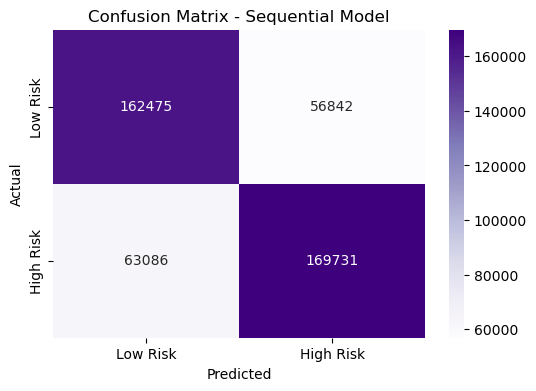

In [31]:
# Classification Report
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype("int32")
print("Model name:", model.__class__.__name__)
#print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Low Risk", "High Risk"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=["Low Risk", "High Risk"],
            yticklabels=["Low Risk", "High Risk"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Sequential Model")
plt.show()

In [30]:
# save the model
model.save("models/sequential_model.h5")